In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OneHotEncoder
import datetime

In [3]:
def return_series(csv_path):
    """
    
    """
    
    def parse(x):
        return datetime.datetime.strptime(x, '%m/%d/%Y %H')
    
    df = pd.read_csv(csv_path, parse_dates=[['Date','Hour']], date_parser=parse)
    
    conditions = [
    df['Plaza ID'].eq(21) | df['Plaza ID'].eq(1),
    df['Plaza ID'].eq(22) | df['Plaza ID'].eq(2),
    df['Plaza ID'].eq(23) | df['Plaza ID'].eq(3),
    df['Plaza ID'].eq(24) | df['Plaza ID'].eq(4),
    df['Plaza ID'].eq(25) | df['Plaza ID'].eq(5),
    df['Plaza ID'].eq(26) | df['Plaza ID'].eq(6),
    df['Plaza ID'].eq(27) | df['Plaza ID'].eq(7),
    df['Plaza ID'].eq(28) | df['Plaza ID'].eq(8),
    df['Plaza ID'].eq(29) | df['Plaza ID'].eq(9),
    df['Plaza ID'].eq(30) | df['Plaza ID'].eq(11)
    ]
    choices = [
        'Triboro Bronx',
        'Triboro Manhattan',
        'Whitestone',
        'Henry Hudson',
        'Marine Parkway',
        'Cross Bay',
        'Queens Midtown',
        'Brooklyn Battery',
        'Throgs Neck',
        'Verrazano'
    ]
    df['plaza_id'] = np.select(conditions, choices, 0)
    
    df['total_count'] = df['# Vehicles - E-ZPass'] + df['# Vehicles - VToll']
    
#     sub_df = df[['Date_Hour', 'plaza_id', 'total_count']]
#     sub_df.columns = ['datetime', 'plaza_id', 'total_count']
#     sub_df.set_index('datetime', inplace=True)
#     sub_df = sub_df.groupby('plaza_id')['total_count'].resample('1D').sum()
    
    return df


In [4]:
df = return_series('mta.csv')

In [5]:
df

,Date_Hour,Plaza ID,Direction,# Vehicles - E-ZPass,# Vehicles - VToll,plaza_id,total_count
0,2020-09-12 00:00:00,21,I,1650,550,Triboro Bronx,2200
1,2020-09-12 01:00:00,21,I,1130,349,Triboro Bronx,1479
2,2020-09-12 02:00:00,21,I,793,276,Triboro Bronx,1069
3,2020-09-12 03:00:00,21,I,691,230,Triboro Bronx,921
4,2020-09-12 04:00:00,21,I,861,173,Triboro Bronx,1034
...,...,...,...,...,...,...,...
1646250,2010-01-01 19:00:00,11,I,2675,1152,Verrazano,3827
1646251,2010-01-01 20:00:00,11,I,2580,1086,Verrazano,3666
1646252,2010-01-01 21:00:00,11,I,2302,987,Verrazano,3289
1646253,2010-01-01 22:00:00,11,I,2170,910,Verrazano,3080


In [6]:
df.columns = ['datetime', 'Plaza ID', 'direction', 'ezpass', 'vtoll', 'plaza_id', 'total_count']
df

,datetime,Plaza ID,direction,ezpass,vtoll,plaza_id,total_count
0,2020-09-12 00:00:00,21,I,1650,550,Triboro Bronx,2200
1,2020-09-12 01:00:00,21,I,1130,349,Triboro Bronx,1479
2,2020-09-12 02:00:00,21,I,793,276,Triboro Bronx,1069
3,2020-09-12 03:00:00,21,I,691,230,Triboro Bronx,921
4,2020-09-12 04:00:00,21,I,861,173,Triboro Bronx,1034
...,...,...,...,...,...,...,...
1646250,2010-01-01 19:00:00,11,I,2675,1152,Verrazano,3827
1646251,2010-01-01 20:00:00,11,I,2580,1086,Verrazano,3666
1646252,2010-01-01 21:00:00,11,I,2302,987,Verrazano,3289
1646253,2010-01-01 22:00:00,11,I,2170,910,Verrazano,3080


In [11]:
_df = df[['datetime', 'ezpass','vtoll', 'plaza_id']]
# _df.set_index('datetime', inplace=True)
_df

,datetime,ezpass,vtoll,plaza_id
0,2020-09-12 00:00:00,1650,550,Triboro Bronx
1,2020-09-12 01:00:00,1130,349,Triboro Bronx
2,2020-09-12 02:00:00,793,276,Triboro Bronx
3,2020-09-12 03:00:00,691,230,Triboro Bronx
4,2020-09-12 04:00:00,861,173,Triboro Bronx
...,...,...,...,...
1646250,2010-01-01 19:00:00,2675,1152,Verrazano
1646251,2010-01-01 20:00:00,2580,1086,Verrazano
1646252,2010-01-01 21:00:00,2302,987,Verrazano
1646253,2010-01-01 22:00:00,2170,910,Verrazano


In [85]:
_melt = pd.melt(_df, id_vars=['plaza_id','datetime'], value_vars=['ezpass', 'vtoll'])

In [86]:
_melt.set_index('datetime',inplace=True)
_melt = _melt.groupby(['plaza_id', 'variable'])['value'].resample('1H').sum().reset_index()

In [87]:
# _melt['value'] = _melt['value'].replace(to_replace=0, method='ffill')

In [88]:
_melt.set_index('datetime', inplace=True)

In [89]:
_melt2 = _melt.groupby(['plaza_id', 'variable'])['value'].resample('1W').sum().reset_index()

In [90]:
_melt2

,plaza_id,variable,datetime,value
0,Brooklyn Battery,ezpass,2010-01-03,59447
1,Brooklyn Battery,ezpass,2010-01-10,247774
2,Brooklyn Battery,ezpass,2010-01-17,254779
3,Brooklyn Battery,ezpass,2010-01-24,243934
4,Brooklyn Battery,ezpass,2010-01-31,253170
...,...,...,...,...
11175,Whitestone,vtoll,2020-08-16,159898
11176,Whitestone,vtoll,2020-08-23,165859
11177,Whitestone,vtoll,2020-08-30,160973
11178,Whitestone,vtoll,2020-09-06,164224


Text(0.5, 1.0, 'Whitestone Bridge traffic Weekly')

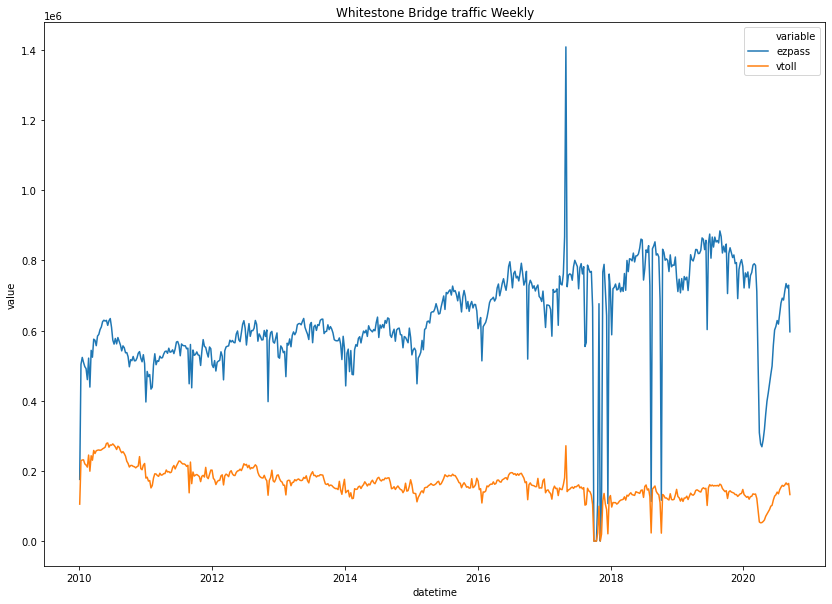

In [91]:
plt.figure(figsize=(14,10))
sns.lineplot(x='datetime', y='value', hue='variable', data = _melt2.loc[_melt2['plaza_id'].eq('Whitestone')])
plt.title('Whitestone Bridge traffic Weekly')

Text(0.5, 1.0, 'Henry Hudson Bridge traffic Weekly')

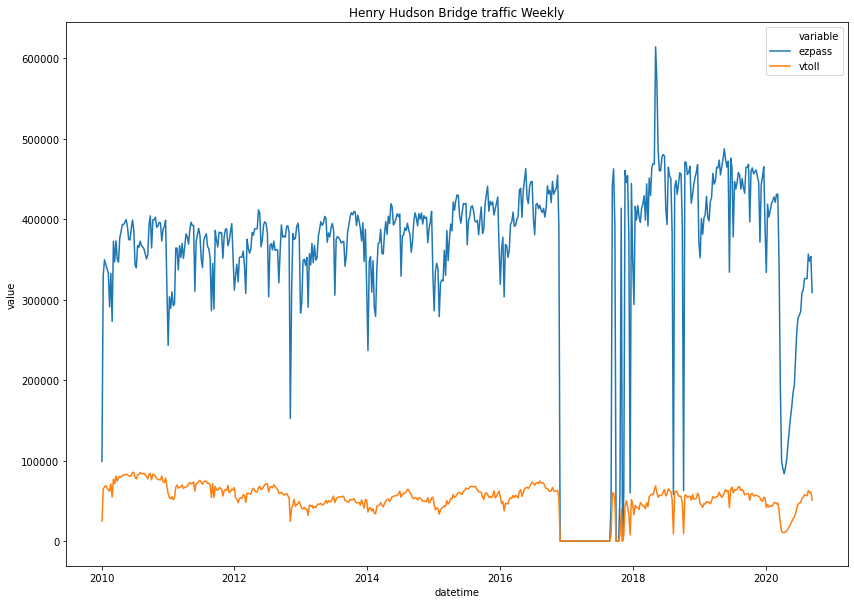

In [94]:
plt.figure(figsize=(14,10))
sns.lineplot(x='datetime', y='value', hue='variable', data = _melt2.loc[_melt2['plaza_id'].eq('Henry Hudson')])
plt.title('Henry Hudson Bridge traffic Weekly')

Text(0.5, 1.0, 'Queens Midtown Bridge traffic Weekly')

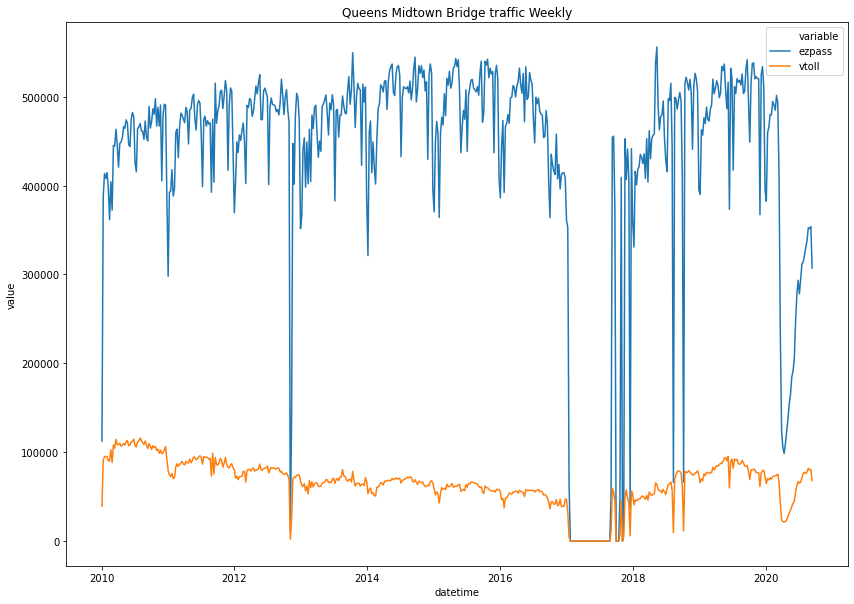

In [95]:
plt.figure(figsize=(14,10))
sns.lineplot(x='datetime', y='value', hue='variable', data = _melt2.loc[_melt2['plaza_id'].eq('Queens Midtown')])
plt.title('Queens Midtown Bridge traffic Weekly')

Text(0.5, 1.0, 'Brooklyn Battery Bridge traffic Weekly')

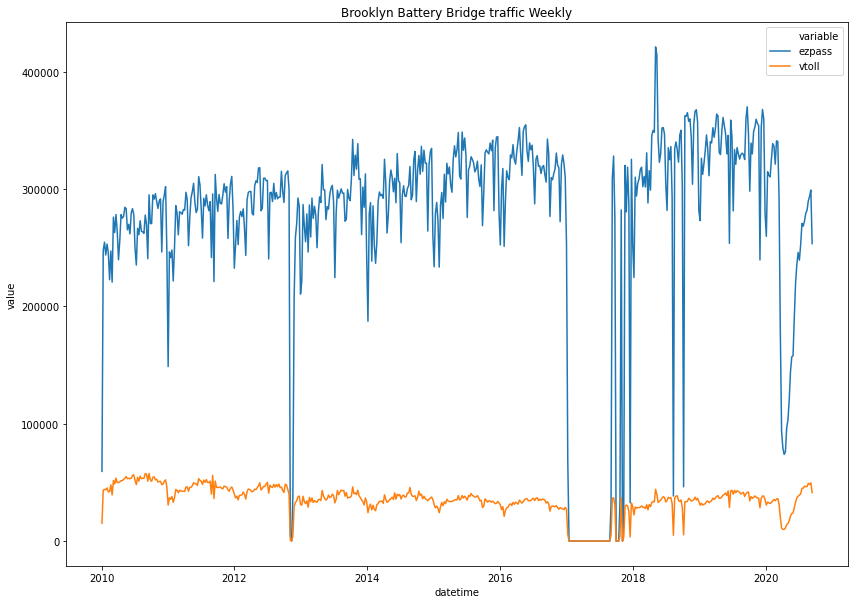

In [96]:
plt.figure(figsize=(14,10))
sns.lineplot(x='datetime', y='value', hue='variable', data = _melt2.loc[_melt2['plaza_id'].eq('Brooklyn Battery')])
plt.title('Brooklyn Battery Bridge traffic Weekly')

Text(0.5, 1.0, 'Brooklyn Battery Bridge traffic Weekly')

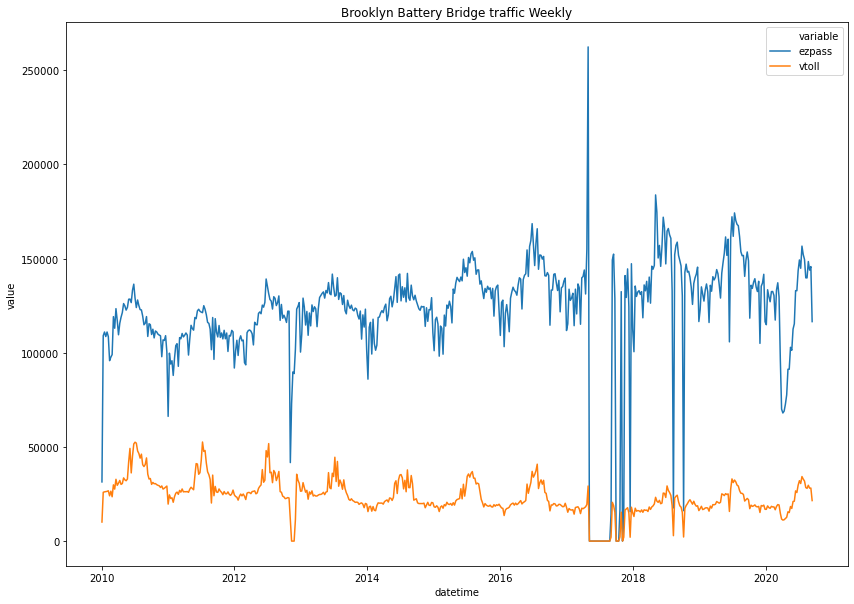

In [97]:
plt.figure(figsize=(14,10))
sns.lineplot(x='datetime', y='value', hue='variable', data = _melt2.loc[_melt2['plaza_id'].eq('Cross Bay')])
plt.title('Brooklyn Battery Bridge traffic Weekly')

Text(0.5, 1.0, 'Brooklyn Battery Bridge traffic Weekly')

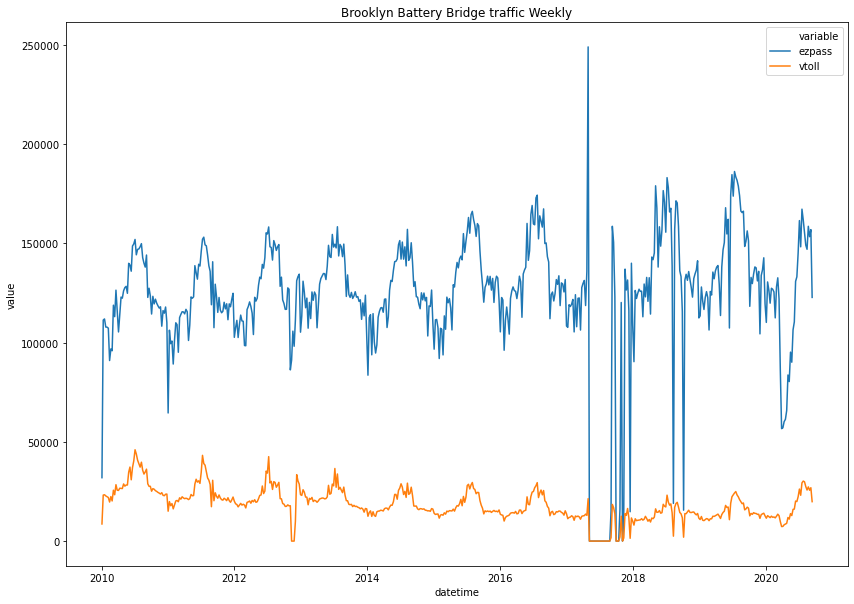

In [98]:
plt.figure(figsize=(14,10))
sns.lineplot(x='datetime', y='value', hue='variable', data = _melt2.loc[_melt2['plaza_id'].eq('Marine Parkway')])
plt.title('Brooklyn Battery Bridge traffic Weekly')

Text(0.5, 1.0, 'Brooklyn Battery Bridge traffic Weekly')

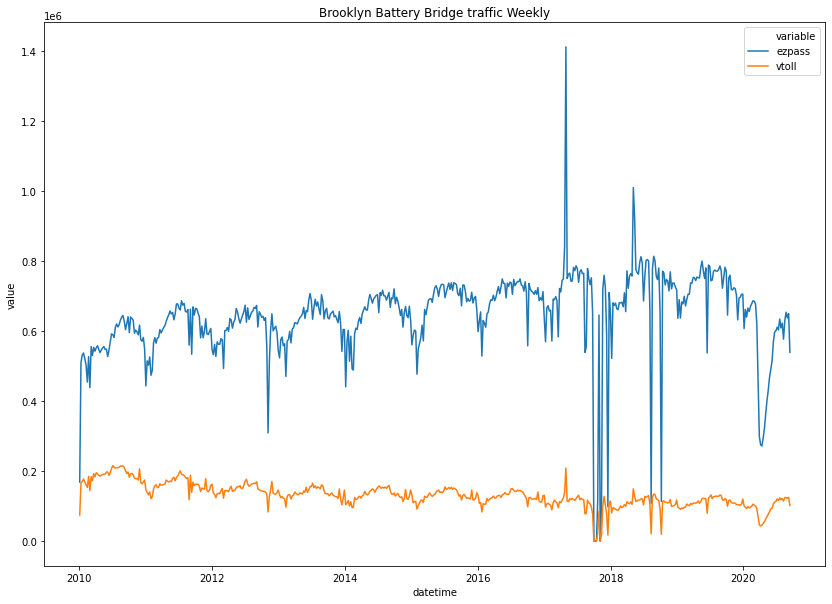

In [99]:
plt.figure(figsize=(14,10))
sns.lineplot(x='datetime', y='value', hue='variable', data = _melt2.loc[_melt2['plaza_id'].eq('Throgs Neck')])
plt.title('Brooklyn Battery Bridge traffic Weekly')

Text(0.5, 1.0, 'Brooklyn Battery Bridge traffic Weekly')

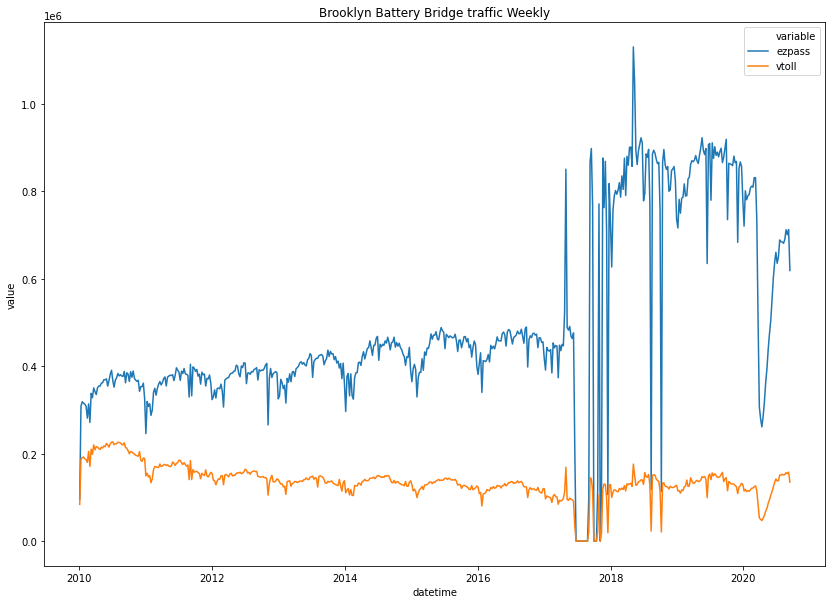

In [100]:
plt.figure(figsize=(14,10))
sns.lineplot(x='datetime', y='value', hue='variable', data = _melt2.loc[_melt2['plaza_id'].eq('Triboro Bronx')])
plt.title('Brooklyn Battery Bridge traffic Weekly')

Text(0.5, 1.0, 'Brooklyn Battery Bridge traffic Weekly')

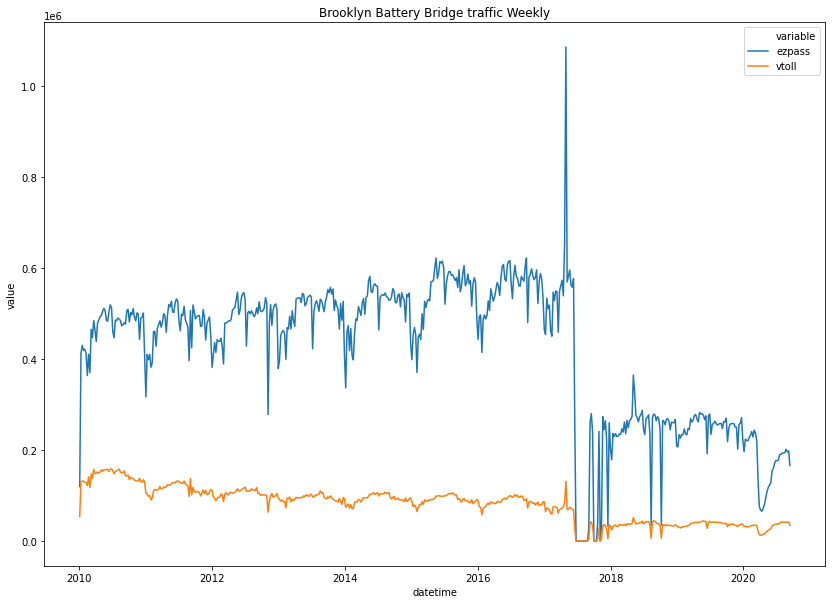

In [101]:
plt.figure(figsize=(14,10))
sns.lineplot(x='datetime', y='value', hue='variable', data = _melt2.loc[_melt2['plaza_id'].eq('Triboro Manhattan')])
plt.title('Brooklyn Battery Bridge traffic Weekly')

Text(0.5, 1.0, 'Brooklyn Battery Bridge traffic Weekly')

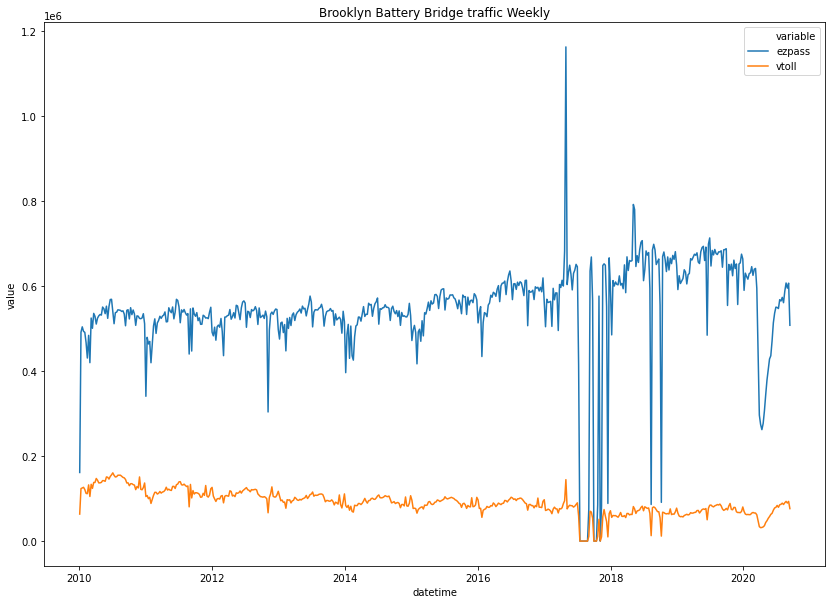

In [102]:
plt.figure(figsize=(14,10))
sns.lineplot(x='datetime', y='value', hue='variable', data = _melt2.loc[_melt2['plaza_id'].eq('Verrazano')])
plt.title('Brooklyn Battery Bridge traffic Weekly')

In [5]:
df = df.unstack().T

In [6]:
df = df['2018':].copy()

In [9]:
for i in df.columns:
    df[i] = df[i].replace(to_replace=0, method='ffill')

In [10]:
_df = df.copy()
_df

plaza_id,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro Bronx,Triboro Manhattan,Verrazano,Whitestone
datetime,,,,,,,,,,
2018-01-01,29163,13705,46540,12118,54907,98346,110224,30551,81923,109286
2018-01-02,47160,21875,60610,19887,67000,106264,129574,35356,95649,117211
2018-01-03,54005,24607,67983,22067,71725,115952,136213,38937,103506,123974
2018-01-04,20484,8303,14502,6167,26625,28406,50867,13270,37820,38114
2018-01-05,38007,16839,49850,13929,55153,80477,105945,29308,74375,91229
...,...,...,...,...,...,...,...,...,...,...
2020-09-08,55105,24644,60591,25524,66662,106502,130435,34153,100146,121270
2020-09-09,56553,22692,62026,22821,67238,104707,128069,35541,99250,118513
2020-09-10,55672,20742,60627,20495,65909,100158,125216,34303,97574,114546
